I've specified a plot_style document that can be loaded with: plt.style.use('/data/notebooks/jupyterlab-biascorrlab/plot_style.txt')

We have 3 different types of dataset (they all have different dimension sizes and so can't really be combined).

The output from our BG fit (a.k.a. observations used for GP fit) is plot using a scatter diagram where the size of the markers needs to be adjusted relative to the density of points and the figure size. It is suggested that this is defined for each plot.

The conditioned data is plot using contourfsince technically our GP is defined over a continuous space. When we apply the change of support onto a grid we can represent the data using a pcolormesh. 

The BG fit to all grid cells data is plot using a pcolormesh, which represents the support of the climate model. 

Note upon researching plotting I noticed that the font size doesn't depend on figure size, however when you change the DPI this scales everything in the figure including the fonts. So the best approach is to specify the DPI and font sizes in a plot_style.txt file which works well with a single column and double column figure size and then the height can be adjusted for each plot depending on the number of rows.

Additional things that need doing:
- Writing the long plotting scripts up as functions in src/plotting_functions
- Adjusting the final plots including the coastline based on updates to include information in ### Plotting Mean and Standard Deviation of Predictions against Observations on Standardised Grid
- The standard deviation in the predictions is the same for p and alpha, this is an error in the code that I believe I've corrected but haven't got round to propagating all the way through to results, which needs doing
- It would be good to write some descriptive text under each plot
- Uncertainty needs calculating in the proper way, where we take lots of realisations of the GPs parameters and predictions and then build up our posterior predictive from that.

In [11]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

# This is a notebook for examining the output of the gp_lima_tinygp.py script. 

In [255]:
import arviz as az
import numpy as np
import jax.numpy as jnp
import xarray as xr

import os
import matplotlib.pyplot as plt

plt.style.use("/data/notebooks/jupyterlab-biascorrlab/plot_style.txt")
os.environ["PROJ_LIB"] = "C:\\Utilities\\Python\\Anaconda\\Library\\share"
# fixr
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from textwrap import wrap

cm = 1 / 2.54  # centimeters in inches
sc = 7.9 * cm  # single_column
dc = 18.2 * cm  # double_column

from src.helper_functions import unstandardise
from src.helper_functions import grid_coords_to_2d_latlon_coords
from src.helper_functions import build_gp
from src.helper_functions import standardise

from src.plotting_functions import pcolormesh_basemapplot
from src.plotting_functions import scatter_basemapplot

<IPython.core.display.Javascript object>

In [14]:
# Loading GP inference data
gp_idata_path = f"/data/notebooks/jupyterlab-biascorrlab/data/Lima2021/AP_Daily_Snowfall_044_GPFit.nc"
gp_idata = az.from_netcdf(gp_idata_path)

<IPython.core.display.Javascript object>

In [15]:
az.summary(gp_idata)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_kern_var,0.014,0.005,0.007,0.022,0.000,0.000,746.0,840.0,NaN
alpha_lengthscale,0.660,0.253,0.289,1.121,0.011,0.008,652.0,860.0,NaN
alpha_like_var,0.002,0.001,0.000,0.003,0.000,0.000,939.0,567.0,NaN
alpha_mean,0.759,0.039,0.679,0.826,0.001,0.001,873.0,809.0,NaN
p_kern_var,0.021,0.006,0.012,0.032,0.000,0.000,955.0,669.0,NaN
p_lengthscale,0.714,0.249,0.397,1.161,0.013,0.010,747.0,319.0,NaN
p_like_var,0.001,0.001,0.000,0.004,0.000,0.000,712.0,354.0,NaN
p_mean,0.560,0.050,0.468,0.650,0.002,0.001,1054.0,1041.0,NaN


<IPython.core.display.Javascript object>

## Examining Posterior

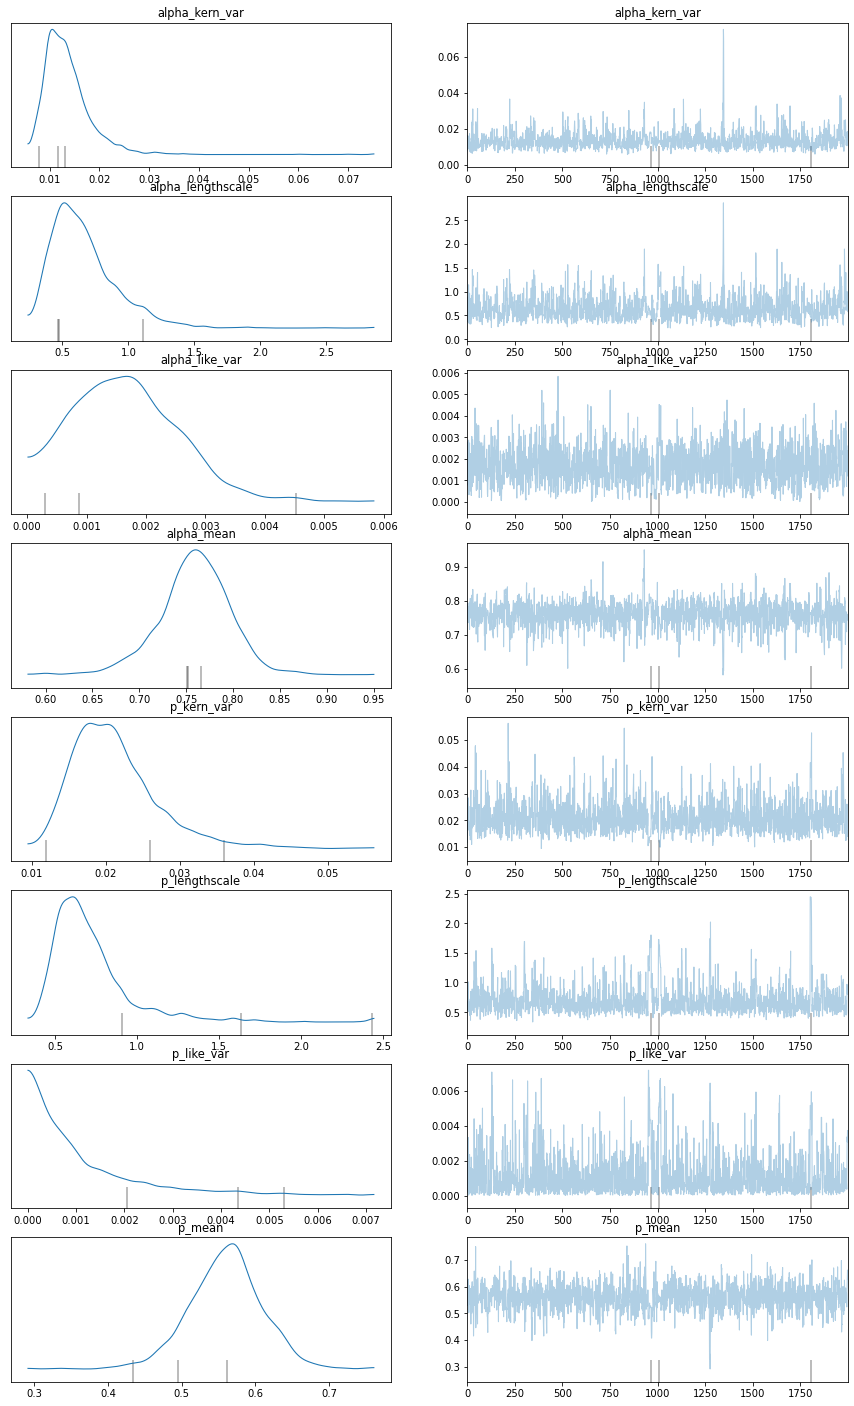

In [4]:
az.plot_trace(gp_idata, compact=True, figsize=(15, 25));

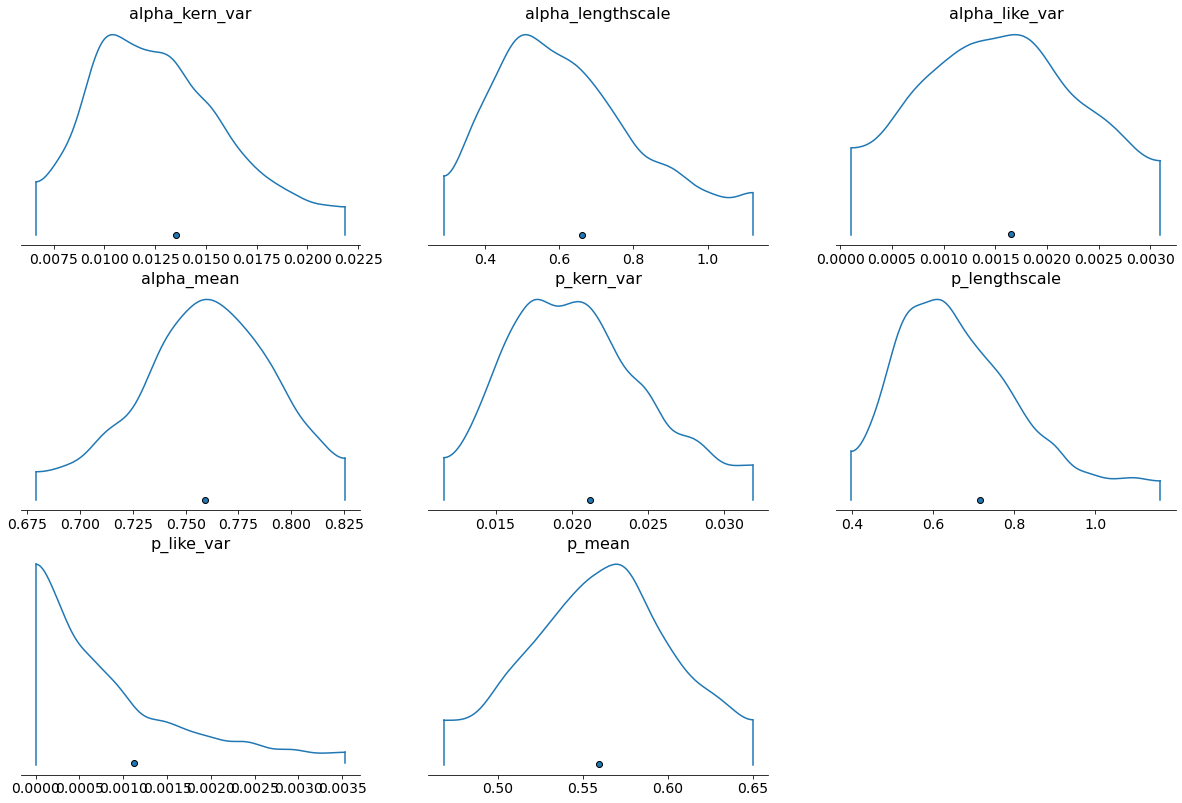

In [5]:
az.plot_density(gp_idata)
plt.show()

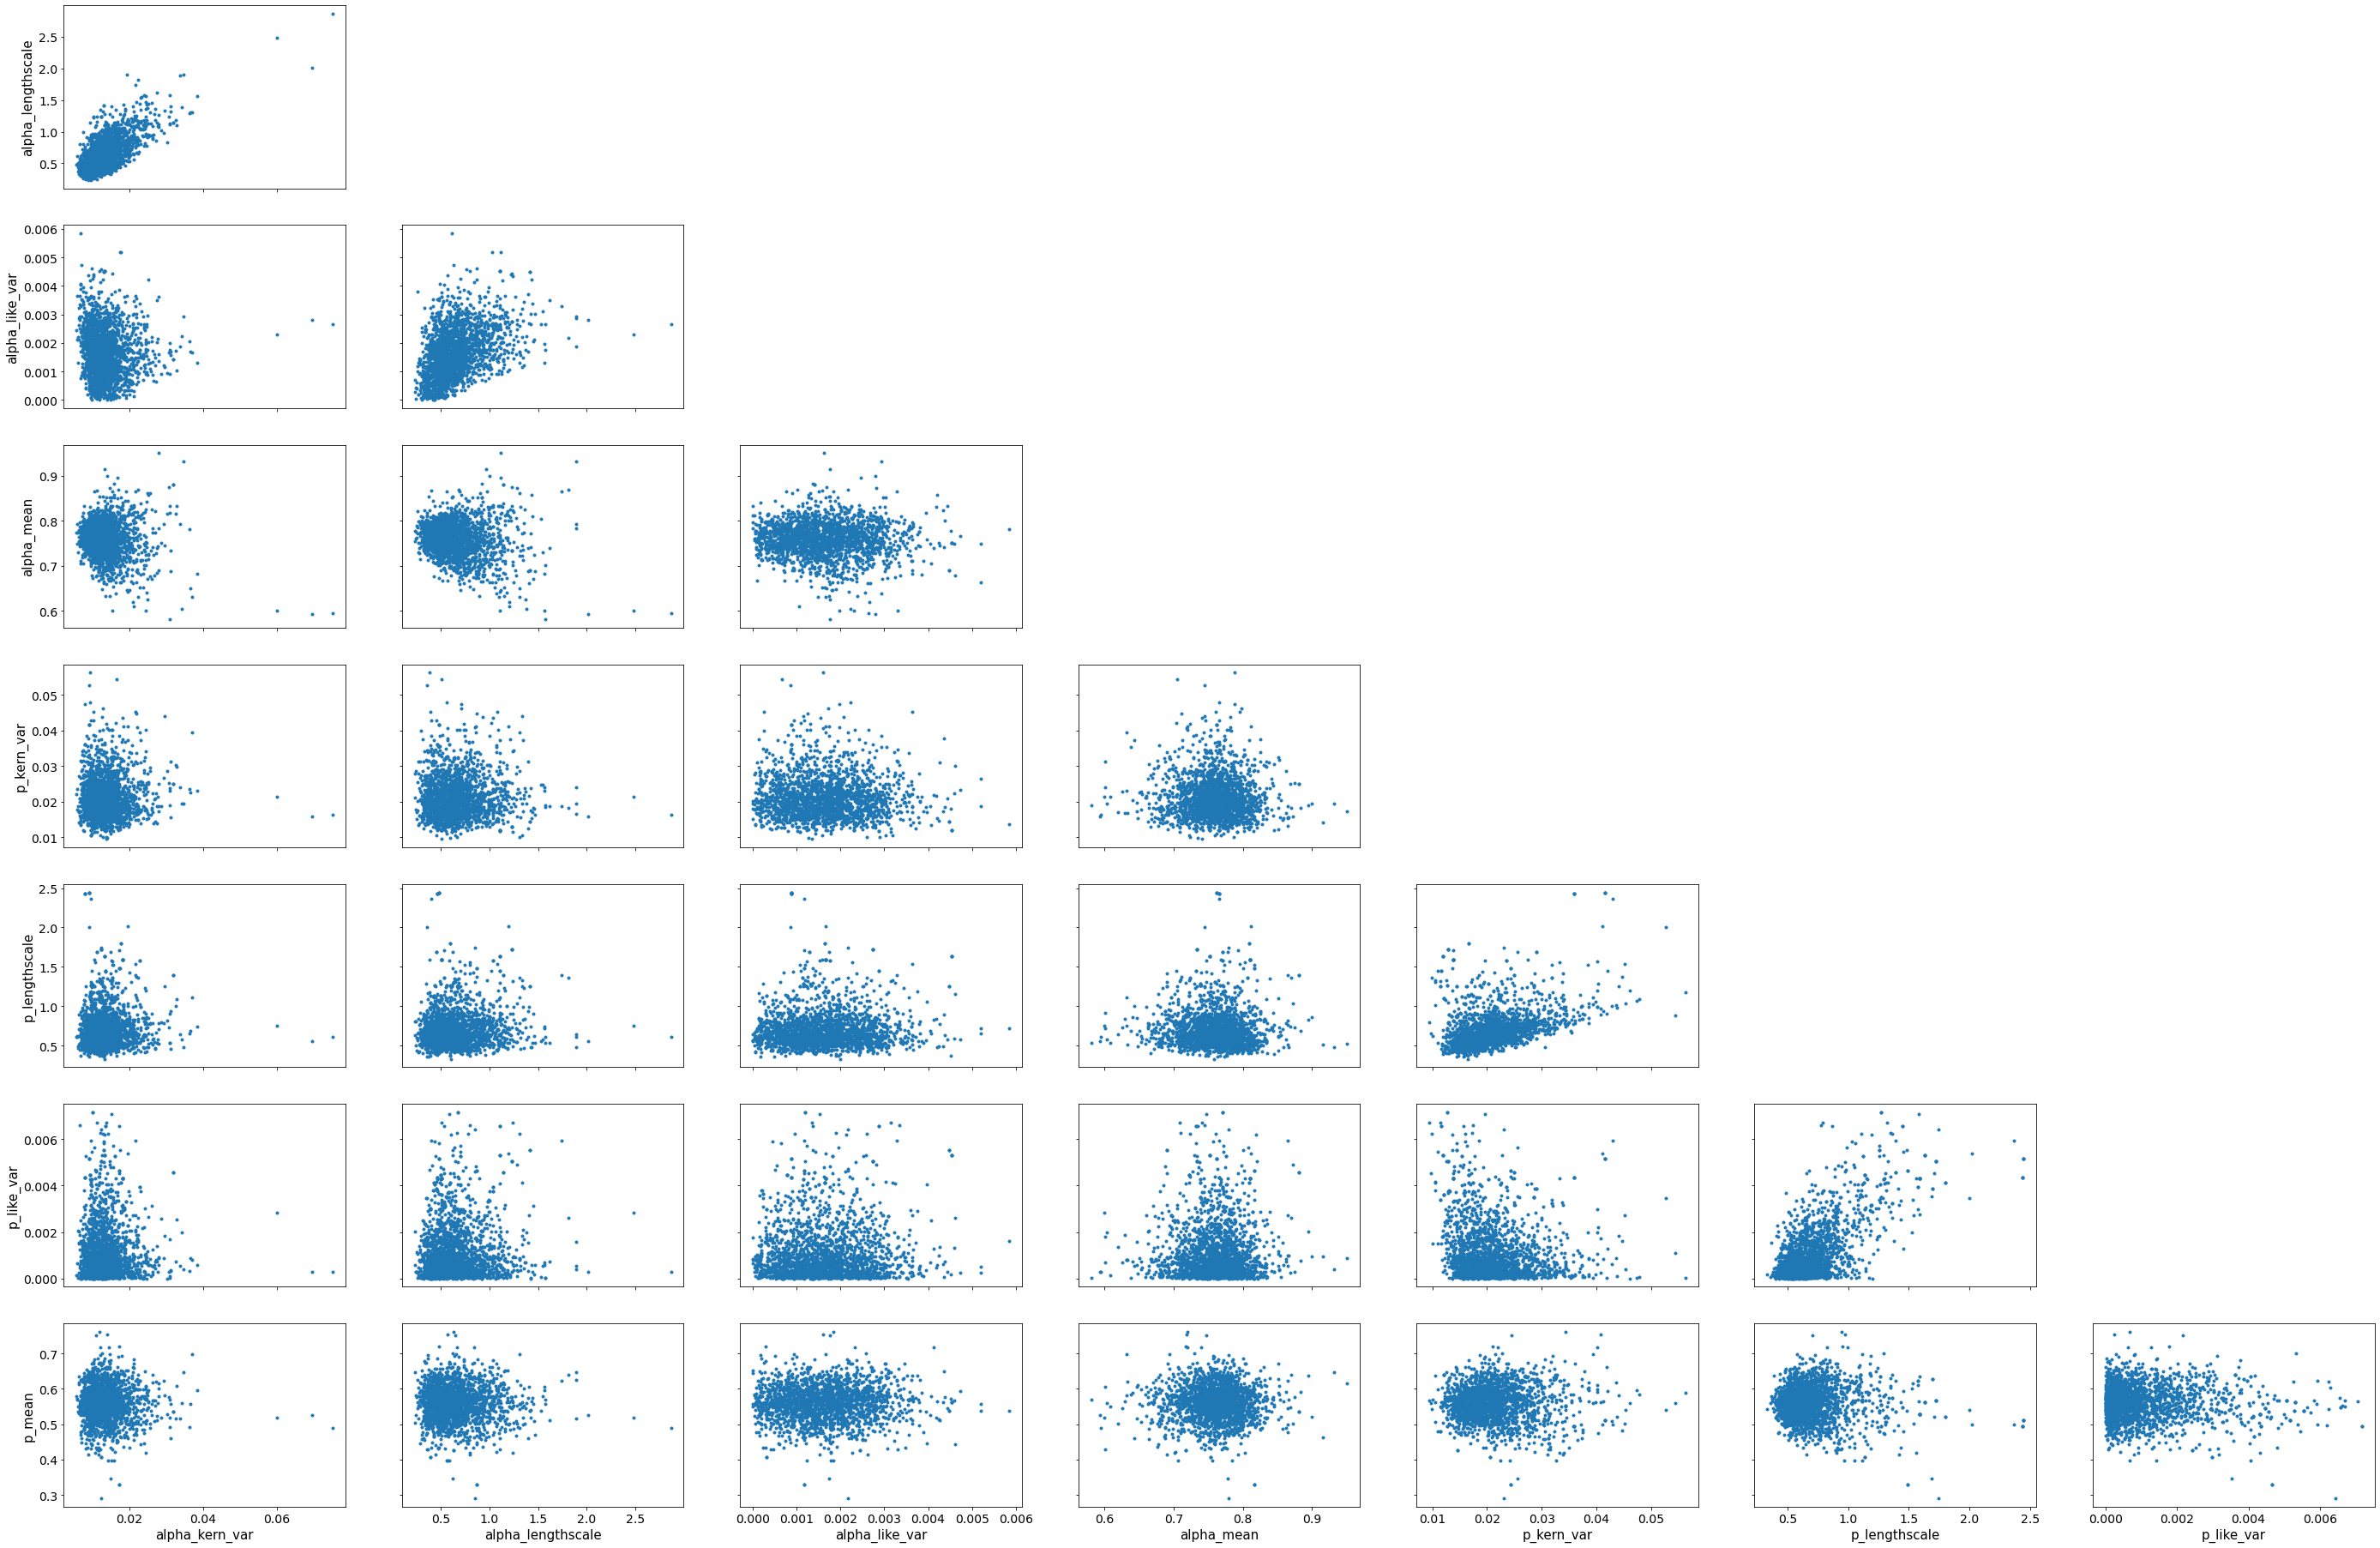

In [5]:
az.plot_pair(gp_idata)
plt.show()

## Conditioning on New Grid (Posterior Predictive)

In [245]:
# Defining new grid to make predictions over
"""coordinates are in standardised units equivalent to the grid_lat_standardised and grid_lon_standardised coordinates used to fit the GP in gp_lima_tinygp.py"""
x_new = np.arange(-3, 3, 0.1)
x_new_grid = np.meshgrid(x_new, x_new)
X_new = np.array(x_new_grid).reshape((2, -1)).T

<IPython.core.display.Javascript object>

In [246]:
# Constructing the GP objects from the inference data
alpha_gp = build_gp(gp_idata, "alpha")
p_gp = build_gp(gp_idata, "p")
# Conditioning based on observed data and on new coordinates
_, alpha_gpcond = alpha_gp.condition(gp_idata.observed_data["alpha"].data, X_new)
_, p_gpcond = alpha_gp.condition(gp_idata.observed_data["p"].data, X_new)

<IPython.core.display.Javascript object>

In [247]:
# Getting the mean and standard deviation of predictions
alpha_mean, alpha_std = alpha_gpcond.mean, np.sqrt(alpha_gpcond.variance)
p_mean, p_std = p_gpcond.mean, np.sqrt(p_gpcond.variance)

<IPython.core.display.Javascript object>

In [248]:
# Placing results into xarray dataset
ds = xr.Dataset(
    data_vars=dict(
        alpha=(
            ["grid_latitude", "grid_longitude", "metric"],
            np.dstack(
                [
                    alpha_mean.reshape((len(x_new), -1)),
                    alpha_std.reshape((len(x_new), -1)),
                ]
            ),
        ),
        p=(
            ["grid_latitude", "grid_longitude", "metric"],
            np.dstack(
                [p_mean.reshape((len(x_new), -1)), p_std.reshape((len(x_new), -1))]
            ),
        ),
    ),
    coords=dict(
        grid_longitude_standardised=("grid_longitude", x_new),
        grid_latitude_standardised=("grid_latitude", x_new),
        grid_longitude=(
            "grid_longitude",
            unstandardise(
                newdata=x_new, refdata=gp_idata.observed_data.grid_longitude.data
            ),
        ),
        grid_latitude=(
            "grid_latitude",
            unstandardise(
                newdata=x_new, refdata=gp_idata.observed_data.grid_latitude.data
            ),
        ),
        metric=("metric", ["mean", "std"]),
    ),
)
# Calculating actual Latitude/Longitude values at new locations and appending to dataset
ds = grid_coords_to_2d_latlon_coords(
    ds,
    "/data/notebooks/jupyterlab-biascorrlab/data/ProcessedData/AP_Daily_Snowfall_044.nc",
)

<IPython.core.display.Javascript object>

## Loading Bernoulli-Gamma fit to all grid cells in domain independently

In [241]:
# Loading BG fit to all grid cells
bg_all_idata_path = f"/data/notebooks/jupyterlab-biascorrlab/data/Lima2021/AP_Daily_Snowfall_All_Observations_BG_Fit.nc"
bg_all_idata = az.from_netcdf(bg_all_idata_path)

<IPython.core.display.Javascript object>

In [243]:
# Adjusting the dimensions to go from sites (1050) back to grid_latitude (30) & grid_longitude (35) - reversing process in simulating_observations.py
base_path = "/data/notebooks/jupyterlab-biascorrlab/data/"
path = f"{base_path}ProcessedData/AP_Daily_Snowfall_044.nc"
original_ds = xr.open_dataset(path)
original_ds_stacked = original_ds.stack(sites=["grid_latitude", "grid_longitude"])

bg_all = bg_all_idata.posterior.copy()
bg_all = bg_all.drop_vars(["grid_latitude", "grid_longitude"])
bg_all = bg_all.assign(sites=original_ds_stacked.get_index("sites"))
bg_all = bg_all.unstack()

<IPython.core.display.Javascript object>

In [253]:
#Adjusting the grid-latitude_standardised and grid_longitude_standardised coordinates such that they align with the standardisation used on the land_only_100 observations dataset
base_path = "/data/notebooks/jupyterlab-biascorrlab/data/"
ref_path = f"{base_path}ProcessedData/AP_Daily_Snowfall_Land_Only_Distributed_Observations_100_Reformatted.nc"
ref_ds = xr.open_dataset(ref_path)

# Create new standardised grid_latitude and grid_longitude coordinates
grid_latitude_standardised = standardise(bg_all.grid_latitude, ref_ds.grid_latitude)
grid_longitude_standardised = standardise(bg_all.grid_longitude, ref_ds.grid_longitude)
bg_all = bg_all.assign_coords(
    grid_latitude_standardised=("grid_latitude", grid_latitude_standardised.data),
    grid_longitude_standardised=("grid_longitude", grid_longitude_standardised.data),
)

<IPython.core.display.Javascript object>

### Plotting Mean and Standard Deviation of Predictions against Observations on Standardised Grid

In [48]:
# Possible option for defining limits on axes
# min_grid_longitude_standardised, max_grid_longitude_standardised = (
#     gp_idata.observed_data.grid_longitude_standardised.min(),
#     gp_idata.observed_data.grid_longitude_standardised.max(),
# )
# min_grid_latitude_standardised, max_grid_latitude_standardised = (
#     gp_idata.observed_data.grid_latitude_standardised.min(),
#     gp_idata.observed_data.grid_latitude_standardised.max(),
# )

<IPython.core.display.Javascript object>

AxesSubplot(0.125,0.657941;0.352273x0.222059)
AxesSubplot(0.547727,0.657941;0.352273x0.222059)
AxesSubplot(0.125,0.391471;0.352273x0.222059)
AxesSubplot(0.547727,0.391471;0.352273x0.222059)
AxesSubplot(0.125,0.125;0.352273x0.222059)
AxesSubplot(0.547727,0.125;0.352273x0.222059)


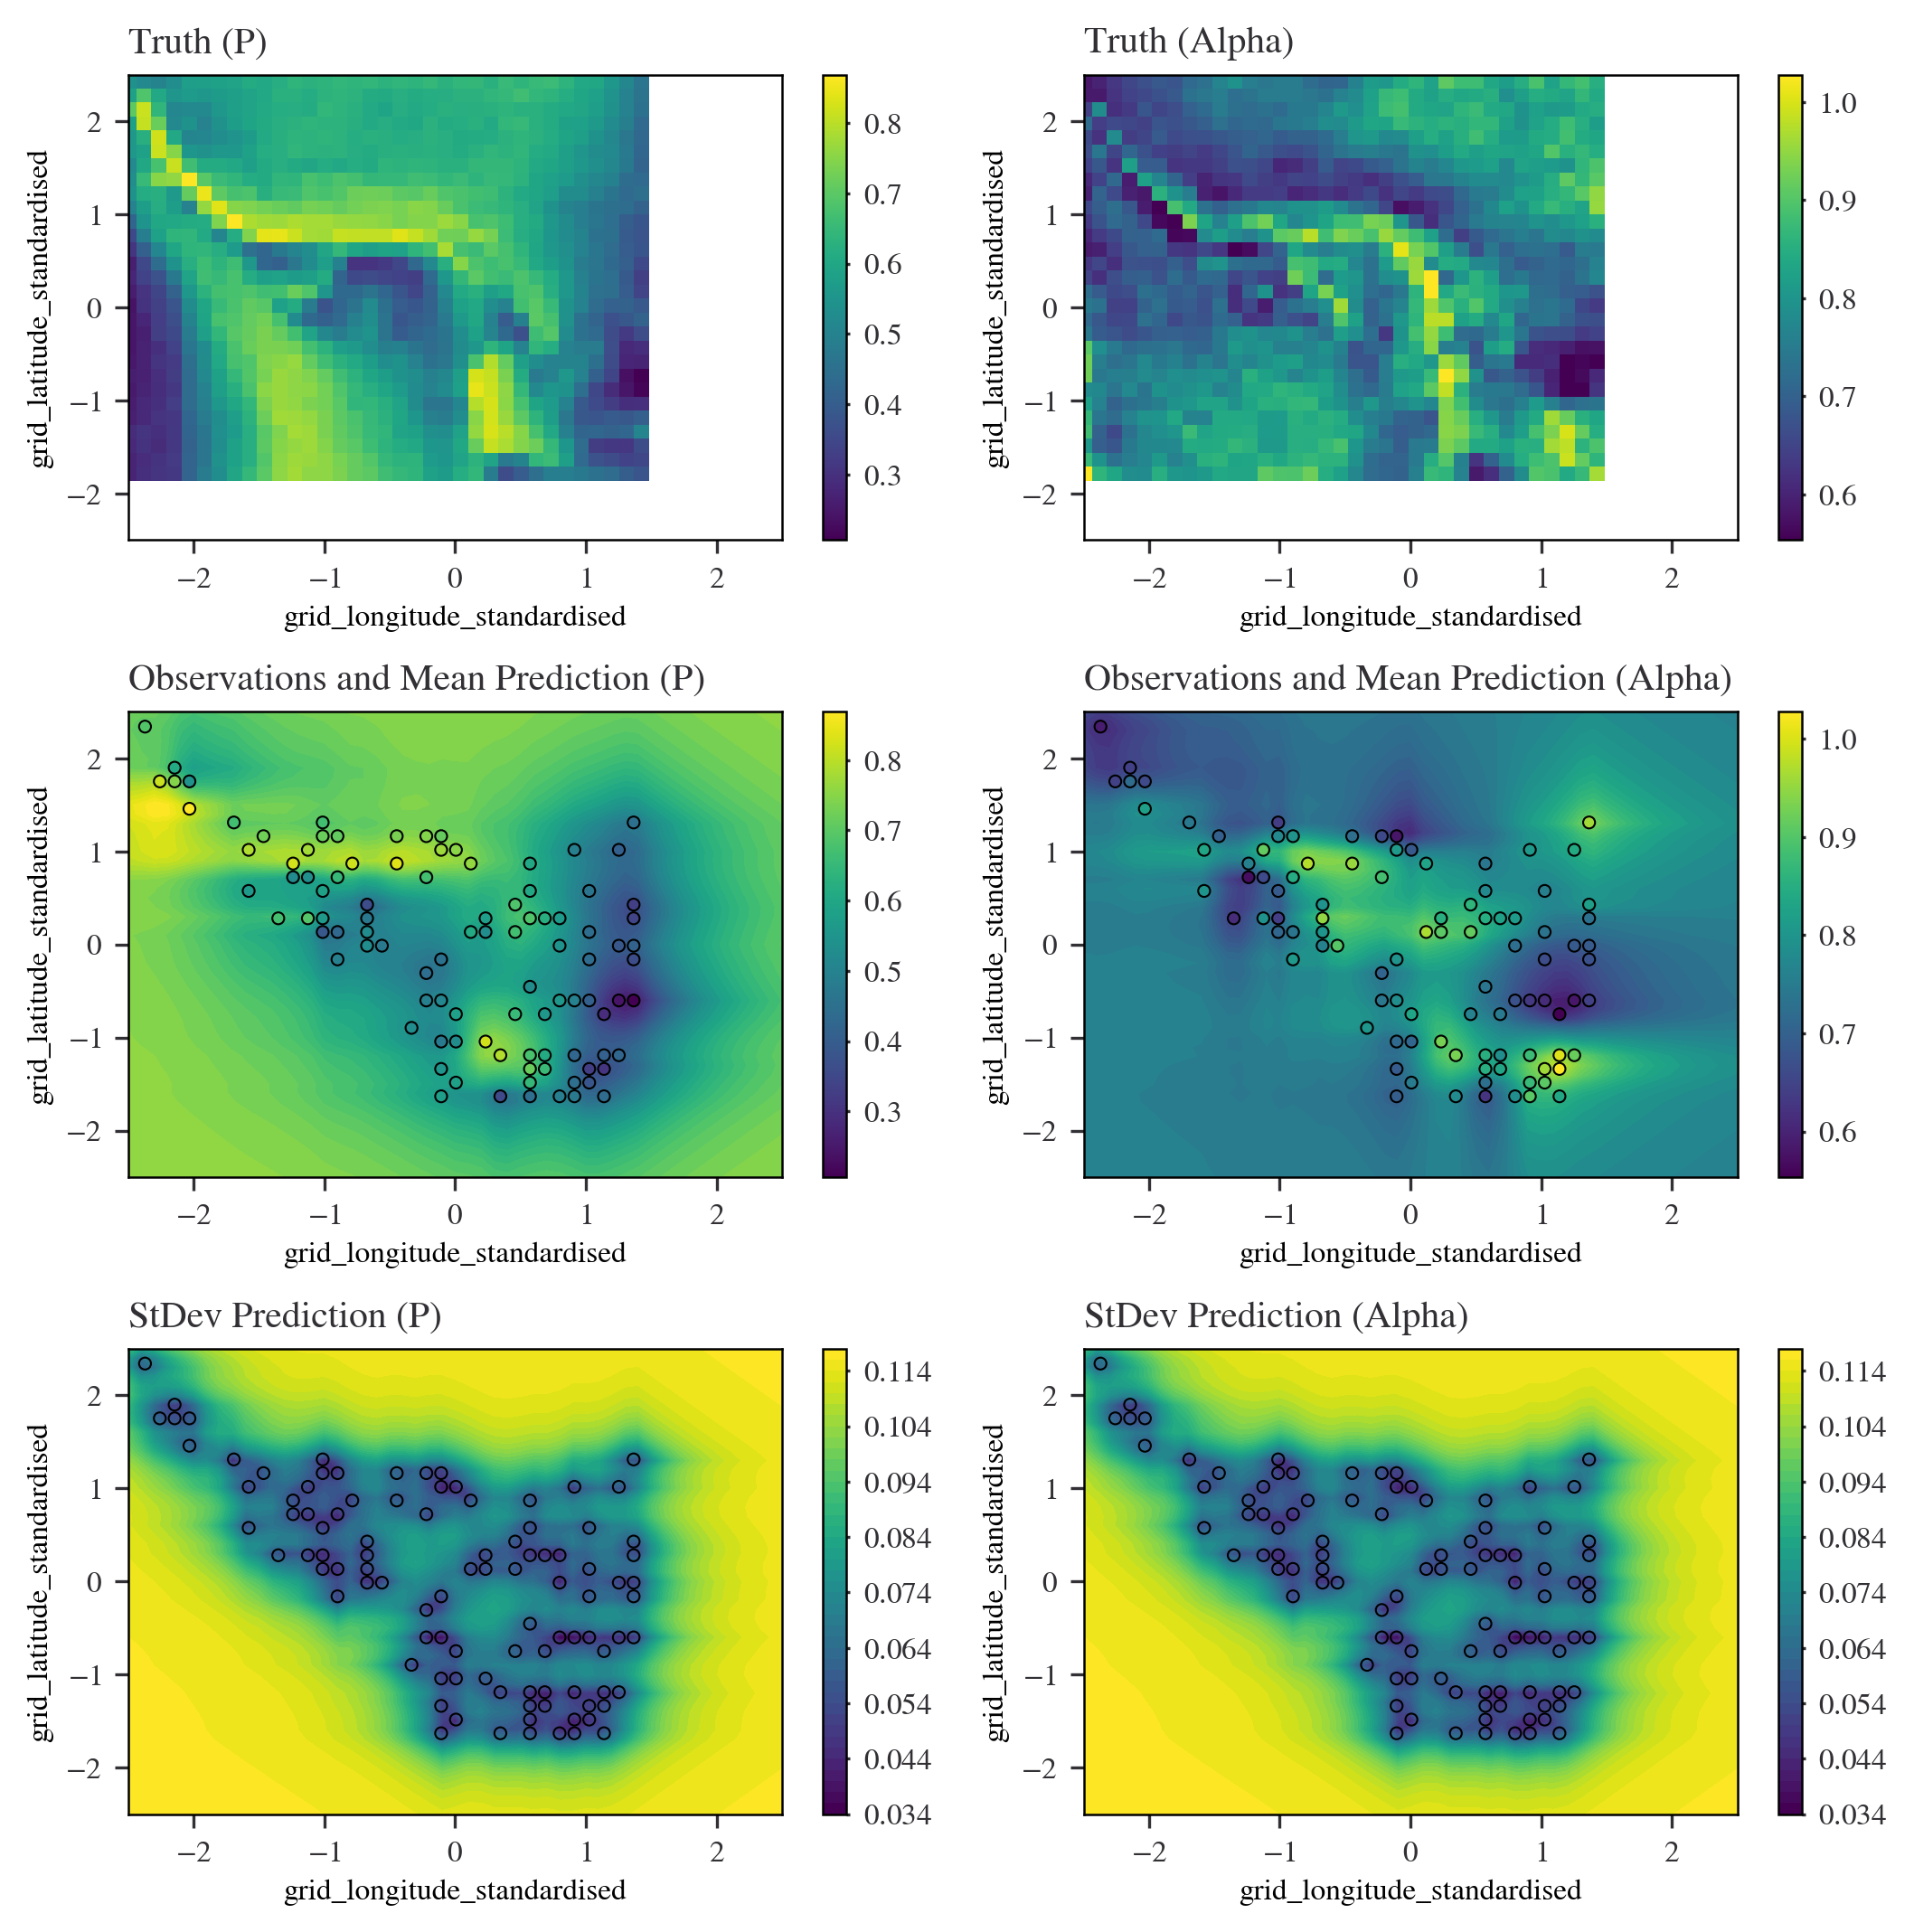

<IPython.core.display.Javascript object>

In [285]:
min_grid_longitude_standardised, max_grid_longitude_standardised = -2.5, 2.5
min_grid_latitude_standardised, max_grid_latitude_standardised = -2.5, 2.5

min_p, max_p = gp_idata.observed_data.p.min(), gp_idata.observed_data.p.max()
min_alpha, max_alpha = (
    gp_idata.observed_data.alpha.min(),
    gp_idata.observed_data.alpha.max(),
)

marker_linewidth = 0.5  # linewidth for scatter plot markers
marker_size = 10  # size for scatter plot markers

fig, axs = plt.subplots(3, 2, figsize=(dc, dc))
plots = []

# 'Truth' Values to Compare Against

plt.subplot(3, 2, 1)
plots.append(
    bg_all.mean(["chain", "draw", "months"])["p"].plot.pcolormesh(
        x="grid_longitude_standardised",
        y="grid_latitude_standardised",
        vmin=min_p,
        vmax=max_p,
        add_colorbar=False,
        zorder=-1,
    )
)
plt.title("Truth (P)")


plt.subplot(3, 2, 2)
plots.append(
    bg_all.mean(["chain", "draw", "months"])["alpha"].plot.pcolormesh(
        x="grid_longitude_standardised",
        y="grid_latitude_standardised",
        vmin=min_alpha,
        vmax=max_alpha,
        add_colorbar=False,
        zorder=-1,
    )
)
plt.title("Truth (Alpha)")


# 'Observations' used and predictions from GP

plt.subplot(3, 2, 3)
plots.append(
    gp_idata.observed_data.plot.scatter(
        x="grid_longitude_standardised",
        y="grid_latitude_standardised",
        hue="p",
        s=marker_size,
        linewidths=marker_linewidth,
        vmin=min_p,
        vmax=max_p,
        add_guide=False,
    )
)
ds.sel(metric="mean")["p"].plot.contourf(
    x="grid_longitude_standardised",
    y="grid_latitude_standardised",
    vmin=min_p,
    vmax=max_p,
    levels=50,
    add_colorbar=False,
    zorder=-1,
)
plt.title("Observations and Mean Prediction (P)")


plt.subplot(3, 2, 4)
plots.append(
    gp_idata.observed_data.plot.scatter(
        x="grid_longitude_standardised",
        y="grid_latitude_standardised",
        hue="alpha",
        s=marker_size,
        linewidths=marker_linewidth,
        vmin=min_alpha,
        vmax=max_alpha,
        add_guide=False,
    )
)
ds.sel(metric="mean")["alpha"].plot.contourf(
    x="grid_longitude_standardised",
    y="grid_latitude_standardised",
    vmin=min_alpha,
    vmax=max_alpha,
    levels=50,
    add_colorbar=False,
    zorder=-1,
)
plt.title("Observations and Mean Prediction (Alpha)")


# Observation locations and Standard deviation in predictions from GP

plt.subplot(3, 2, 5)
plots.append(
    ds.sel(metric="std")["p"].plot.contourf(
        x="grid_longitude_standardised",
        y="grid_latitude_standardised",
        # vmin=min_p,
        # vmax=max_p,
        levels=50,
        add_colorbar=False,
        zorder=-1,
    )
)
gp_idata.observed_data.plot.scatter(
    x="grid_longitude_standardised",
    y="grid_latitude_standardised",
    facecolors="none",
    s=marker_size,
    linewidths=marker_linewidth,
    vmin=min_alpha,
    vmax=max_alpha,
    add_guide=False,
)
plt.title("StDev Prediction (P)")


plt.subplot(3, 2, 6)
plots.append(
    ds.sel(metric="std")["alpha"].plot.contourf(
        x="grid_longitude_standardised",
        y="grid_latitude_standardised",
        # vmin=min_alpha,
        # vmax=max_alpha,
        levels=50,
        add_colorbar=False,
        zorder=1,
    )
)
gp_idata.observed_data.plot.scatter(
    x="grid_longitude_standardised",
    y="grid_latitude_standardised",
    facecolors="none",
    s=marker_size,
    linewidths=marker_linewidth,
    # vmin=min_alpha,
    # vmax=max_alpha,
    add_guide=False,
)
plt.title("StDev Prediction (Alpha)")


#Adjusting axes limits and creating colorbars that can be customised
for plot, ax in zip(plots, axs.ravel()):
    print(ax)
    ax.set_xlim([min_grid_longitude_standardised, max_grid_longitude_standardised])
    ax.set_ylim([min_grid_latitude_standardised, max_grid_latitude_standardised])

    cbar = fig.colorbar(plot, ax=ax)
    cbar.ax.tick_params(size=1)

plt.tight_layout()

### Plotting Mean of Predictions against Observations on Latitude-Longitude Grid with Coastlines Marked

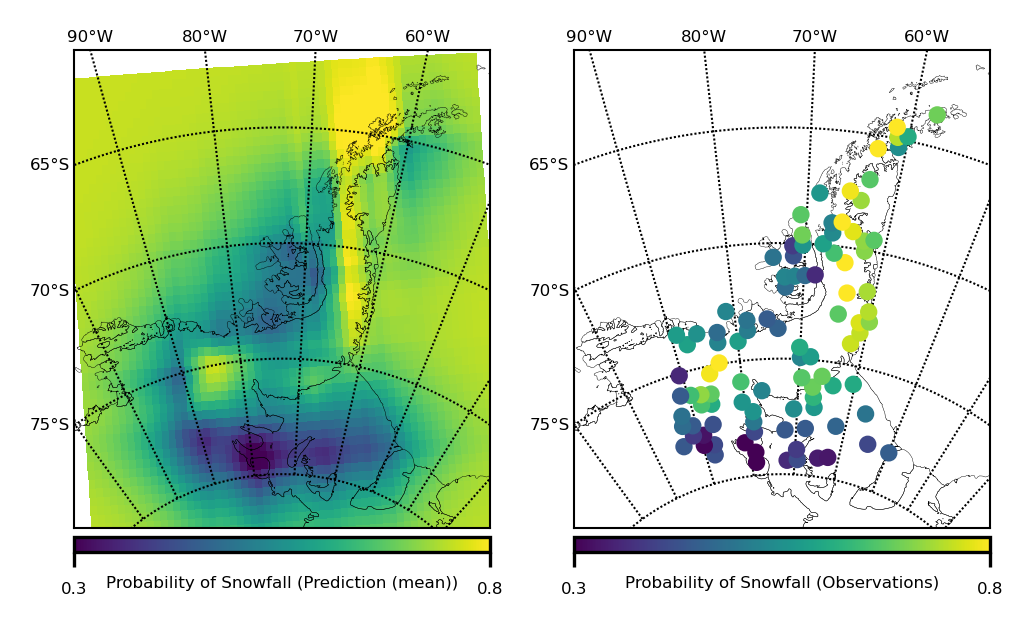

In [11]:
fontsize=4
plt.rcParams.update({'font.size': fontsize})
plots = []
vmin,vmax = 0.3,0.8
variable = 'p'
metric = 'mean'
colorbar_labels = ["\n".join(wrap(f'Probability of Snowfall (Prediction ({metric}))', 100)),"\n".join(wrap('Probability of Snowfall (Observations)', 100))]

antarctica_peninsula_map = Basemap(width=2000000,height=2300000,projection='laea',lat_ts=-30,lat_0=-72,lon_0=-73,resolution='l')
fig, axs = plt.subplots(1, 2, sharex='col', sharey='row',figsize=(10*cm, 6.0*cm),dpi= 300,linewidth=0.1)

plt.subplot(1, 2, 1)
plots.append(pcolormesh_basemapplot(ds,variable,metric,antarctica_peninsula_map,vmin=vmin,vmax=vmax,cmap='viridis',alpha=1))
parallels = np.arange(-90,-60,5)
antarctica_peninsula_map.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.5) # labels = [left,right,top,bottom]
meridians = np.arange(-110,-20,10)
antarctica_peninsula_map.drawmeridians(meridians,labels=[False,False,True,False],linewidth=0.5) # labels = [left,right,top,bottom]

plt.subplot(1, 2, 2)
plots.append(scatter_basemapplot(gp_idata.observed_data,variable,antarctica_peninsula_map,vmin,vmax,cmap='viridis',alpha=1))
parallels = np.arange(-90,-60,5)
antarctica_peninsula_map.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.5) # labels = [left,right,top,bottom]
meridians = np.arange(-110,-20,10)
antarctica_peninsula_map.drawmeridians(meridians,labels=[False,False,True,False],linewidth=0.5) # labels = [left,right,top,bottom]

for plot,axis,colorbar_label in zip(plots,axs,colorbar_labels):
    divider = make_axes_locatable(axis)
    cax = divider.append_axes('bottom', size='3%', pad=0.03)
    cbar = plt.colorbar(plot,cax=cax,orientation="horizontal")
    cbar.set_ticks([vmin, vmax])
    cbar.ax.set_xticklabels([f'{vmin}', f'{vmax}'],fontsize=fontsize)
    cbar.set_label(colorbar_label,labelpad=-5,fontsize=fontsize)

for axis in axs:
    [x.set_linewidth(0.5) for x in axis.spines.values()]
    
plt.show()

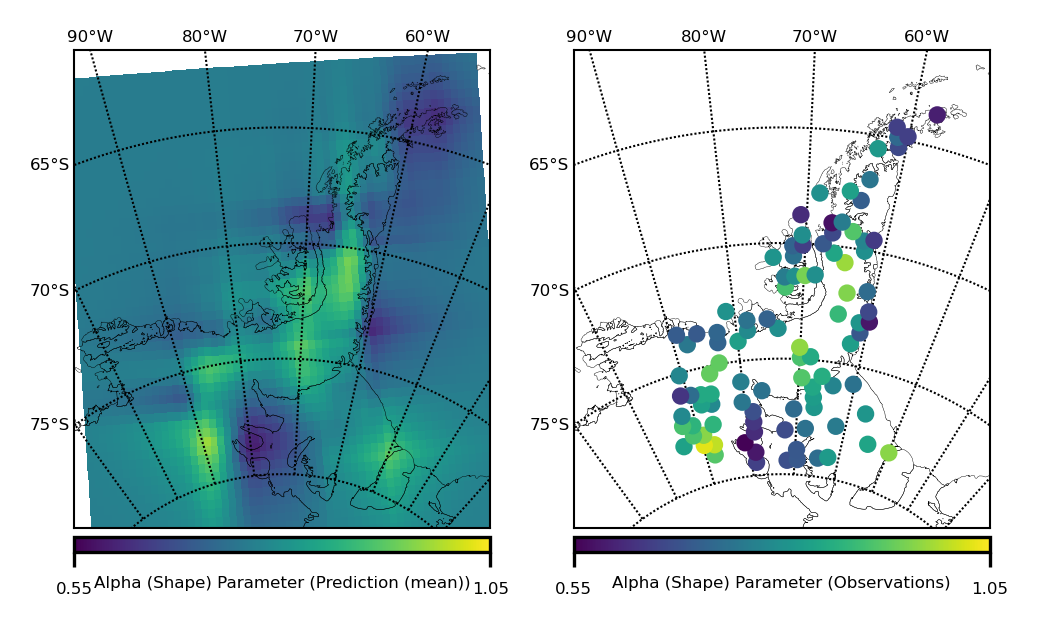

In [12]:
cm = 1/2.54  # centimeters in inches
fontsize=4
plt.rcParams.update({'font.size': fontsize})
plots = []
vmin,vmax = 0.55,1.05
variable = 'alpha'
metric = 'mean'
colorbar_labels = ["\n".join(wrap(f'Alpha (Shape) Parameter (Prediction ({metric}))', 100)),"\n".join(wrap('Alpha (Shape) Parameter (Observations)', 100))]

antarctica_peninsula_map = Basemap(width=2000000,height=2300000,projection='laea',lat_ts=-30,lat_0=-72,lon_0=-73,resolution='l')
fig, axs = plt.subplots(1, 2, sharex='col', sharey='row',figsize=(10*cm, 6.0*cm),dpi= 300,linewidth=0.1)

plt.subplot(1, 2, 1)
plots.append(pcolormesh_basemapplot(ds,variable,metric,antarctica_peninsula_map,vmin=vmin,vmax=vmax,cmap='viridis',alpha=1))
parallels = np.arange(-90,-60,5)
antarctica_peninsula_map.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.5) # labels = [left,right,top,bottom]
meridians = np.arange(-110,-20,10)
antarctica_peninsula_map.drawmeridians(meridians,labels=[False,False,True,False],linewidth=0.5) # labels = [left,right,top,bottom]

plt.subplot(1, 2, 2)
plots.append(scatter_basemapplot(gp_idata.observed_data,variable,antarctica_peninsula_map,vmin,vmax,cmap='viridis',alpha=1))
parallels = np.arange(-90,-60,5)
antarctica_peninsula_map.drawparallels(parallels,labels=[True,False,False,False],linewidth=0.5) # labels = [left,right,top,bottom]
meridians = np.arange(-110,-20,10)
antarctica_peninsula_map.drawmeridians(meridians,labels=[False,False,True,False],linewidth=0.5) # labels = [left,right,top,bottom]

for plot,axis,colorbar_label in zip(plots,axs,colorbar_labels):
    divider = make_axes_locatable(axis)
    cax = divider.append_axes('bottom', size='3%', pad=0.03)
    cbar = plt.colorbar(plot,cax=cax,orientation="horizontal")
    cbar.set_ticks([vmin, vmax])
    cbar.ax.set_xticklabels([f'{vmin}', f'{vmax}'],fontsize=fontsize)
    cbar.set_label(colorbar_label,labelpad=-5,fontsize=fontsize)

for axis in axs:
    [x.set_linewidth(0.5) for x in axis.spines.values()]
    
plt.show()